# Introduction
This report details the development and evaluation of machine learning models to predict stock prices for a hedge fund. The analysis utilizes historical daily Adjusted Close (Adj Close) data for five equities (Apple (AAPL), Microsoft (MSFT), Google (GOOGL), Amazon (AMZN), and Tesla (TSLA)) obtained from Yahoo Finance for the period of January 1, 2020, to January 1, 2024.

# Data Preparation
Data Acquisition: The data was downloaded using the yfinance library.
1. **Cleaning**: Rows with missing values (NaN) were dropped to ensure data integrity for analysis and modeling.
2. **Formatting**: The data was reshaped into a pandas DataFrame with symbols as column names.
3. **Exploration**: Historical price visualizations were generated to understand general trends and potential seasonality.






In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
from pmdarima.arima import auto_arima
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import yfinance as yf


symbols = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA']
df = yf.download(symbols, start='2020-01-01', end='2024-01-01')['Adj Close']
df.columns = symbols
df.dropna(inplace=True)




[*********************100%%**********************]  5 of 5 completed


# EDA
Visualizations of historical closing prices revealed trends, potential seasonality, and volatility patterns for each stock. Seasonal decomposition plots further confirmed these observations, highlighting potential monthly or yearly recurring patterns.





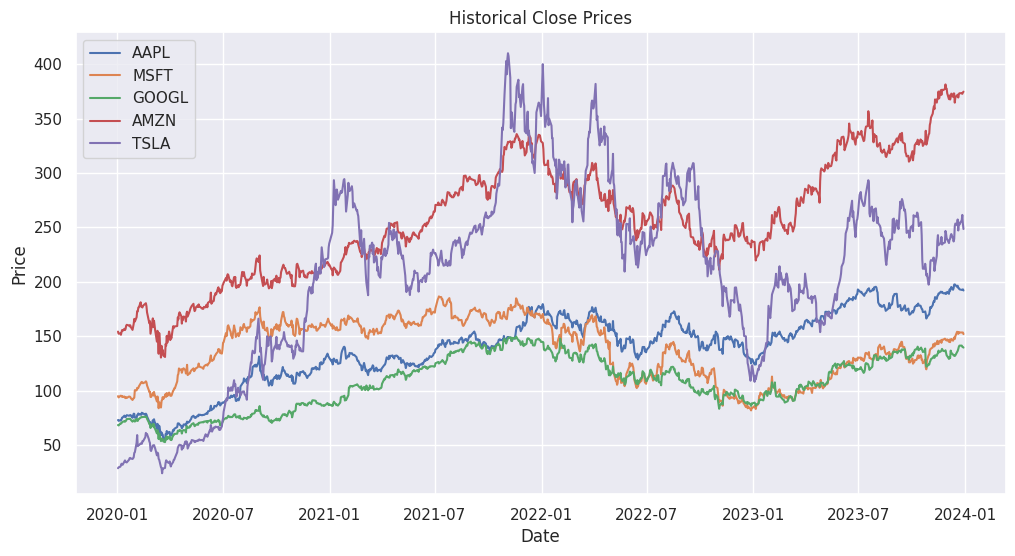

<Figure size 1200x800 with 0 Axes>

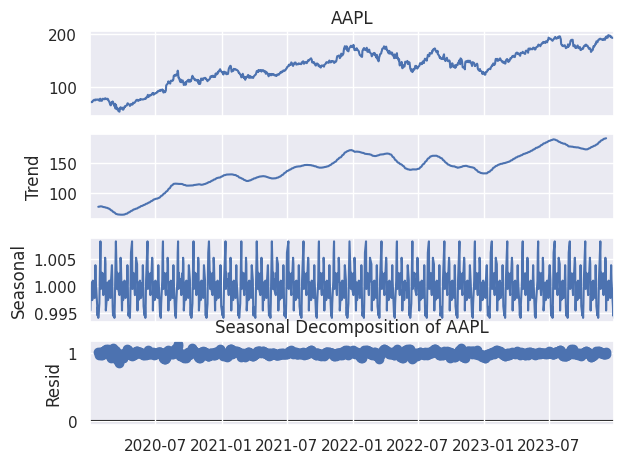

<Figure size 1200x800 with 0 Axes>

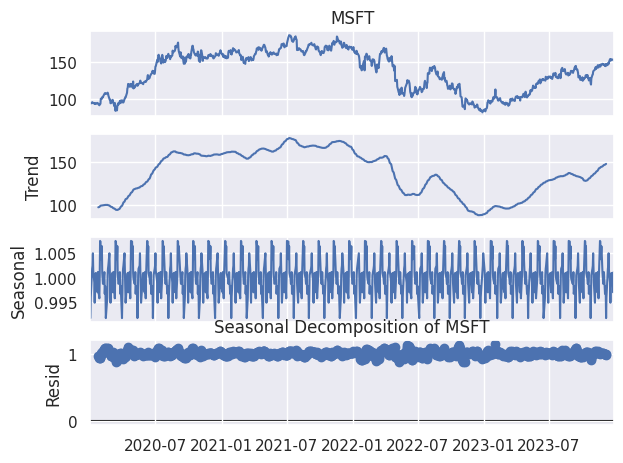

<Figure size 1200x800 with 0 Axes>

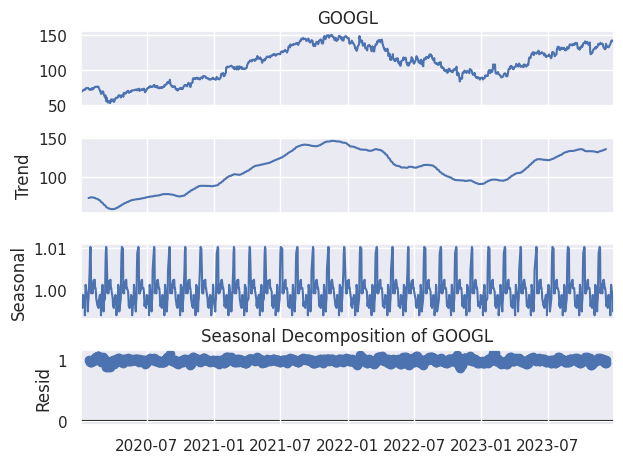

<Figure size 1200x800 with 0 Axes>

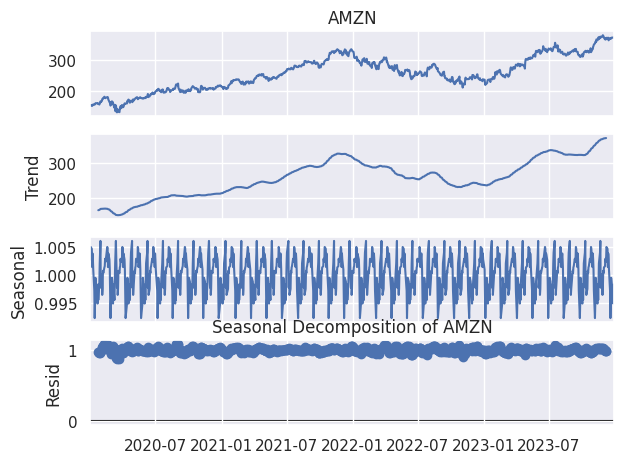

<Figure size 1200x800 with 0 Axes>

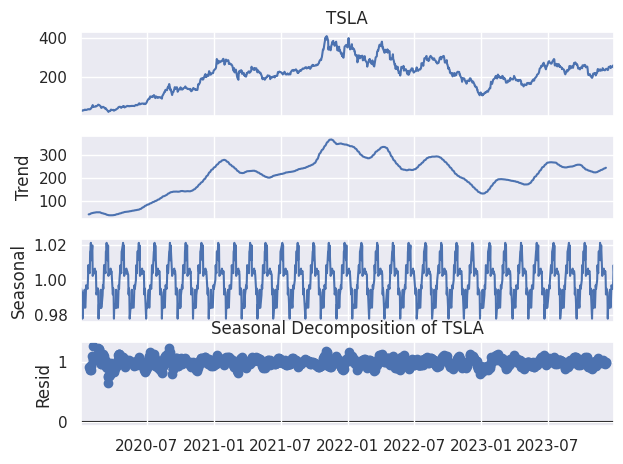

In [18]:
#Plot Historical Prices
plt.figure(figsize=(12, 6))
for symbol in symbols:
    plt.plot(df[symbol], label=symbol)
plt.title('Historical Close Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Seasonal decomposition
for symbol in symbols:
    result = seasonal_decompose(df[symbol], model='multiplicative', period=30)
    fig = plt.figure(figsize=(12, 8))
    fig = result.plot()
    plt.title(f'Seasonal Decomposition of {symbol}')
    plt.show()



In [19]:
def plot_acf_pacf(data, symbol):
    acf_result = acf(data, nlags=30)
    plt.figure(figsize=(12, 6))
    plt.stem(acf_result)
    plt.xlabel('Lag')
    plt.ylabel('ACF')
    plt.title(f'ACF for {symbol}')
    plt.show()

    # PACF plot
    pacf_result = pacf(data, nlags=30)
    plt.figure(figsize=(12, 6))
    plt.stem(pacf_result)
    plt.xlabel('Lag')
    plt.ylabel('PACF')
    plt.title(f'PACF for {symbol}')
    plt.show()



# Feature Engineering
1. **Lagged Features**: The closing price for each stock was shifted by one and two days (denoted as _Close_Lag1 and _Close_Lag2) to capture the influence of past prices.

2. **Rolling Means**: Rolling means with windows of 7 and 30 days (denoted as _Rolling_Mean_7 and _Rolling_Mean_30) were created to capture short-term and long-term price trends.

3. **Percentage Change**: The daily percentage change in closing price (denoted as _Close_Pct_Change) was calculated to analyze price momentum.


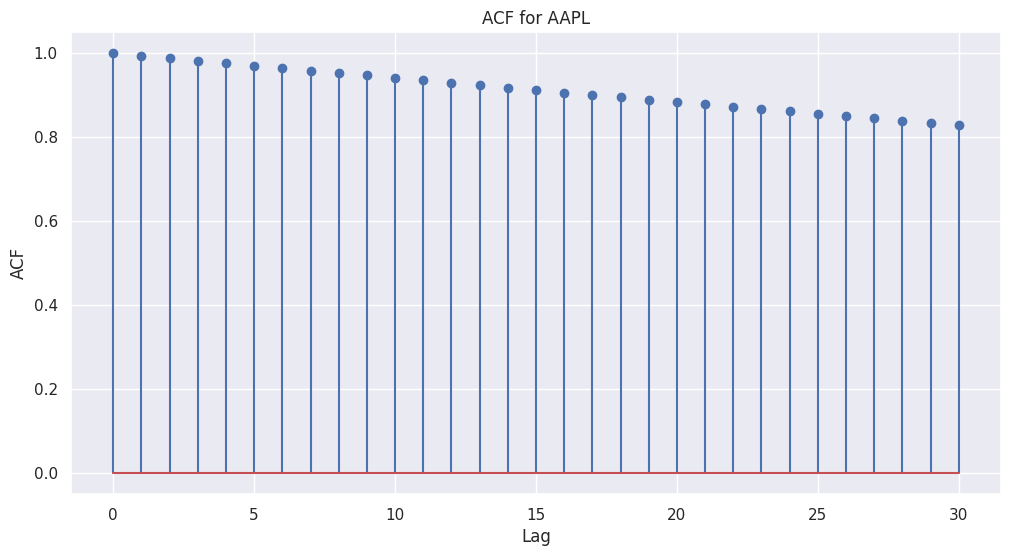

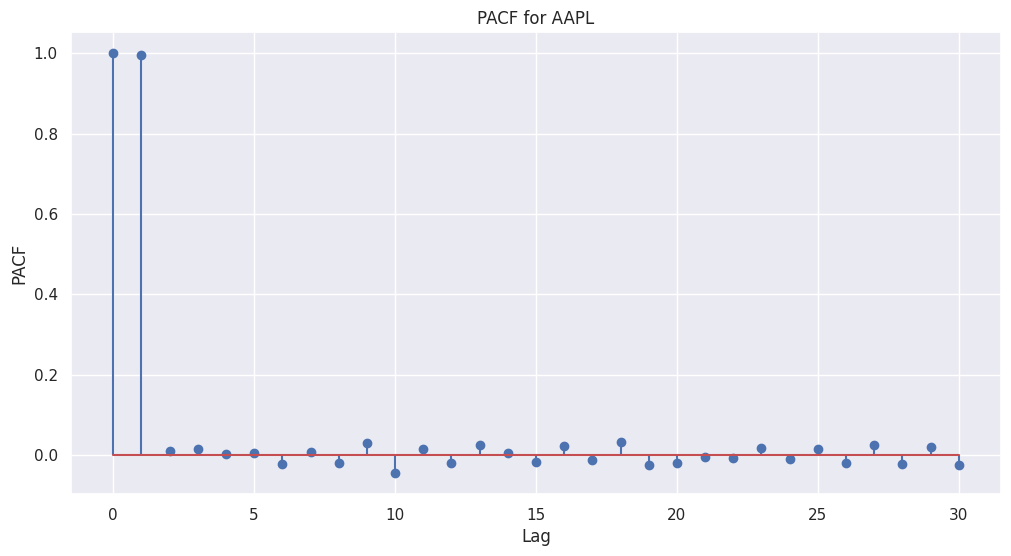

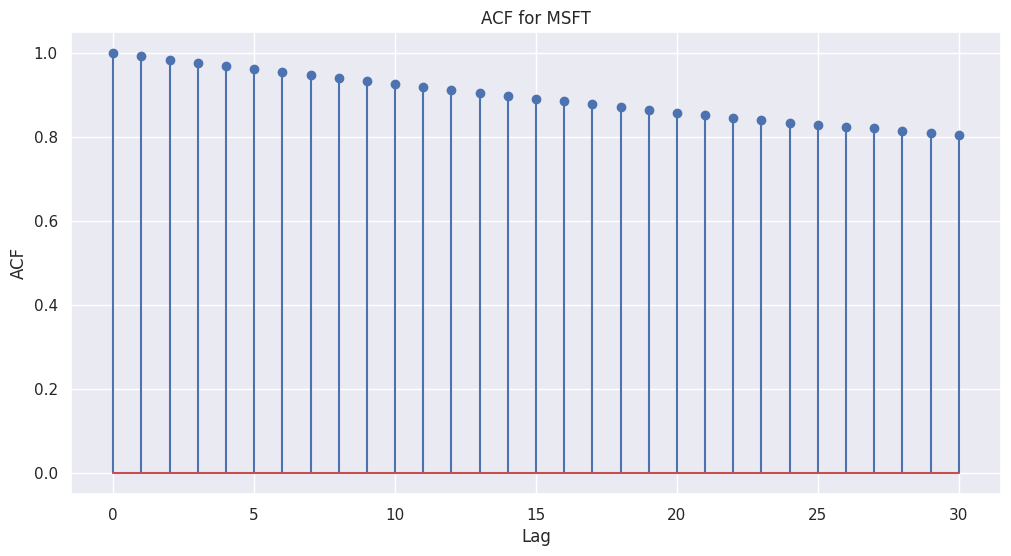

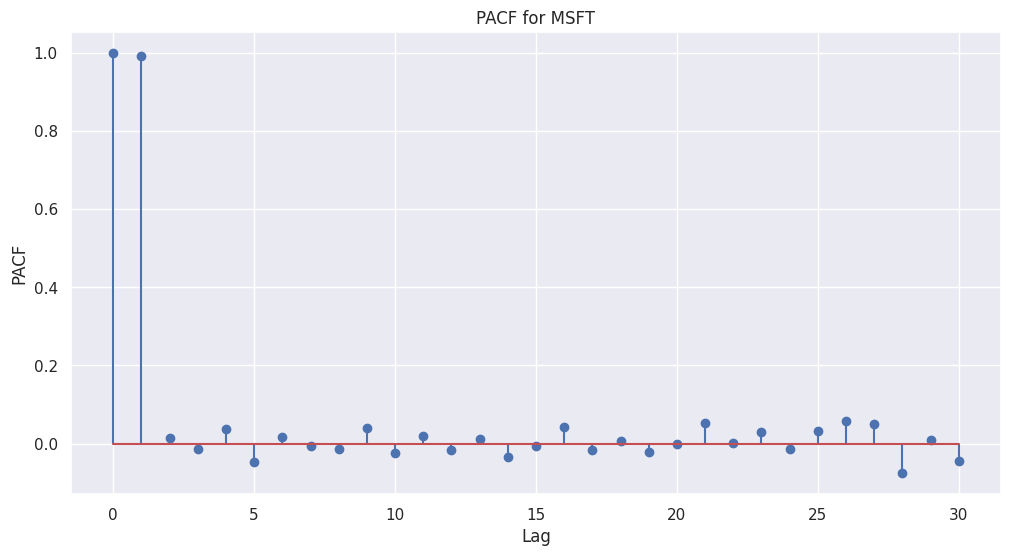

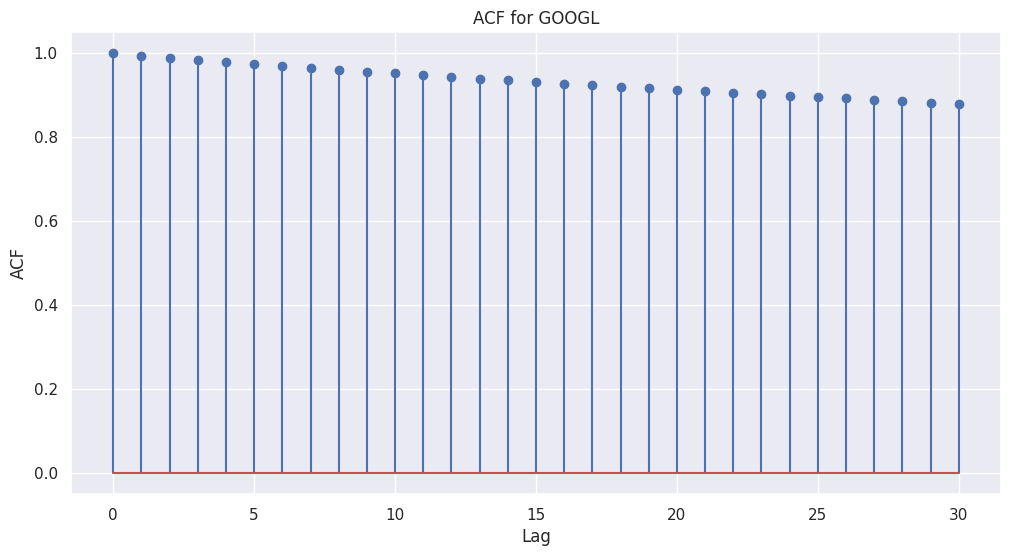

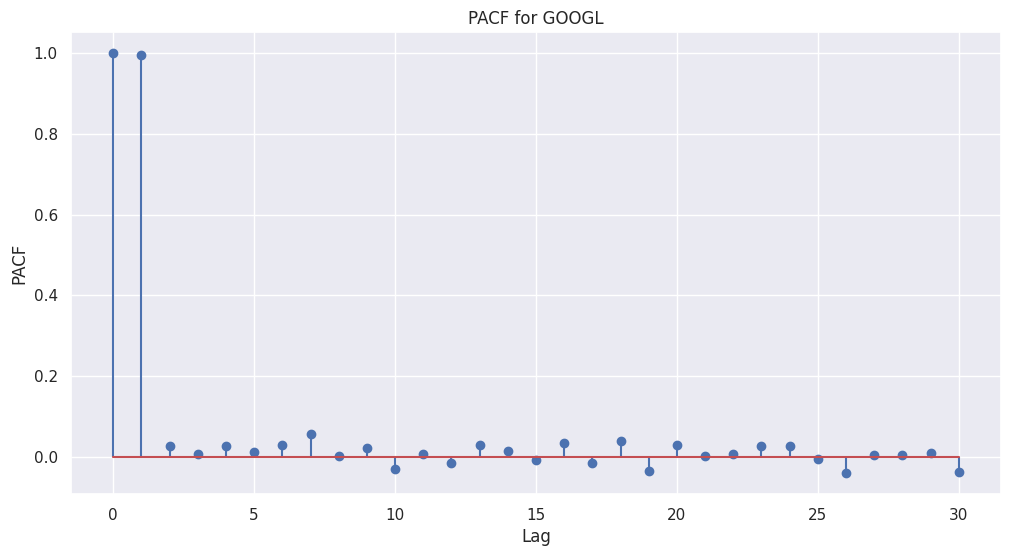

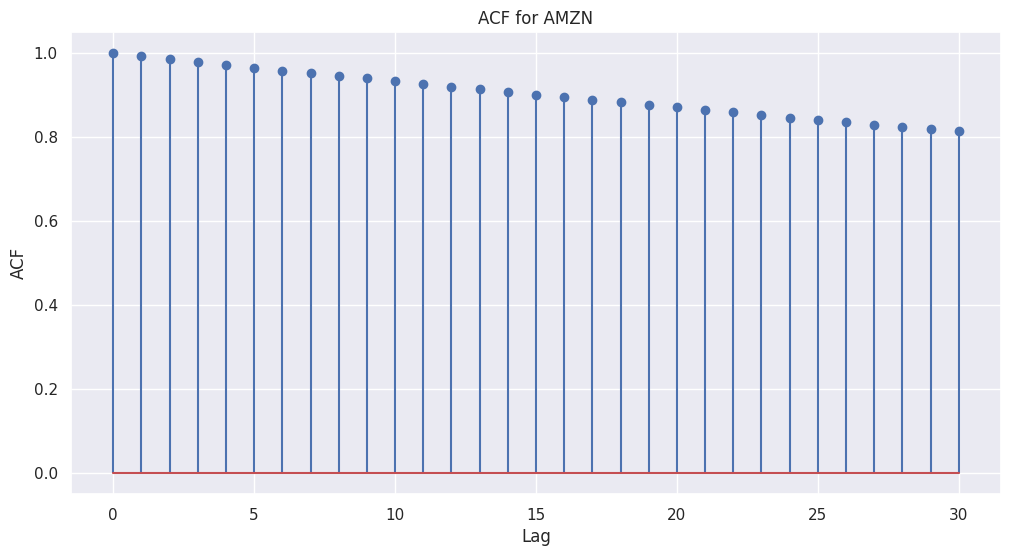

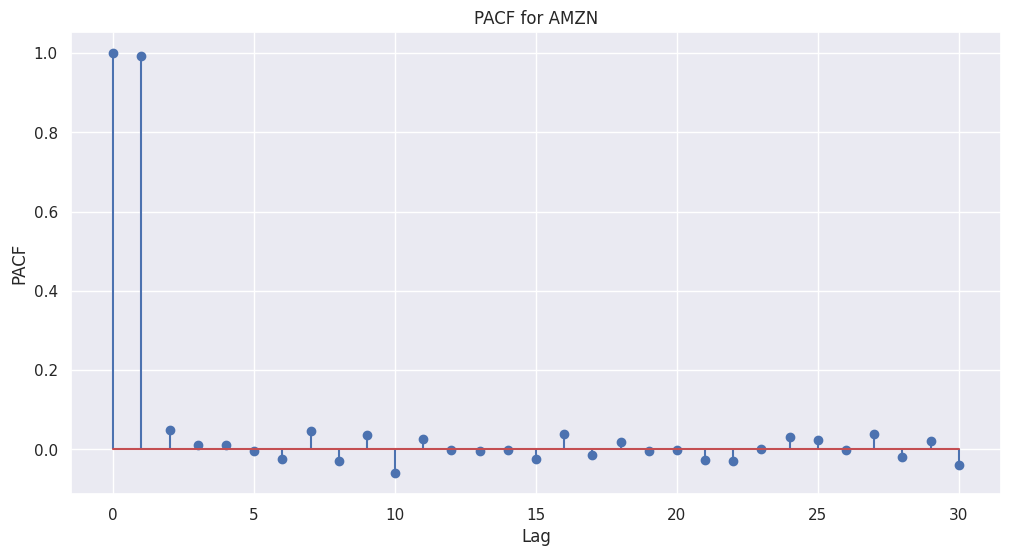

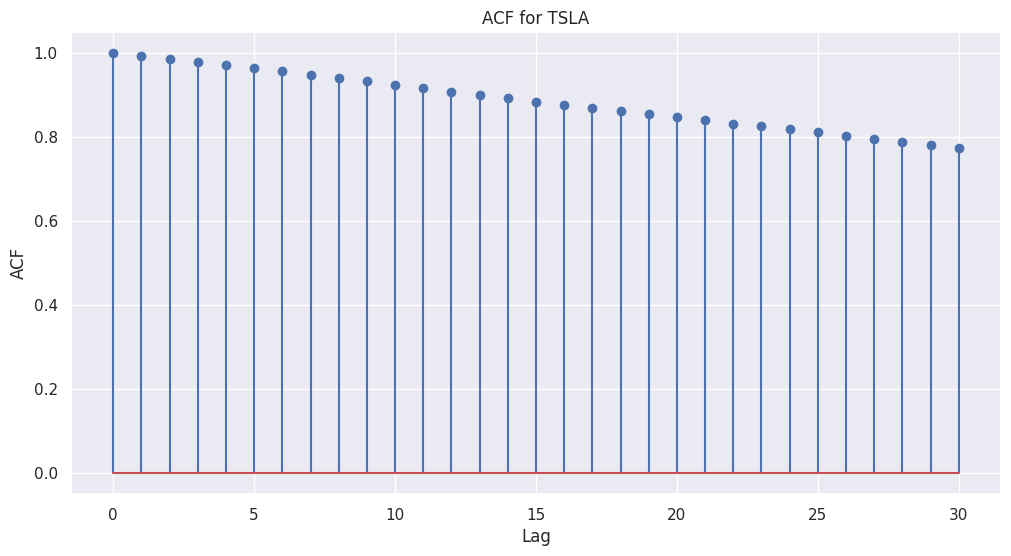

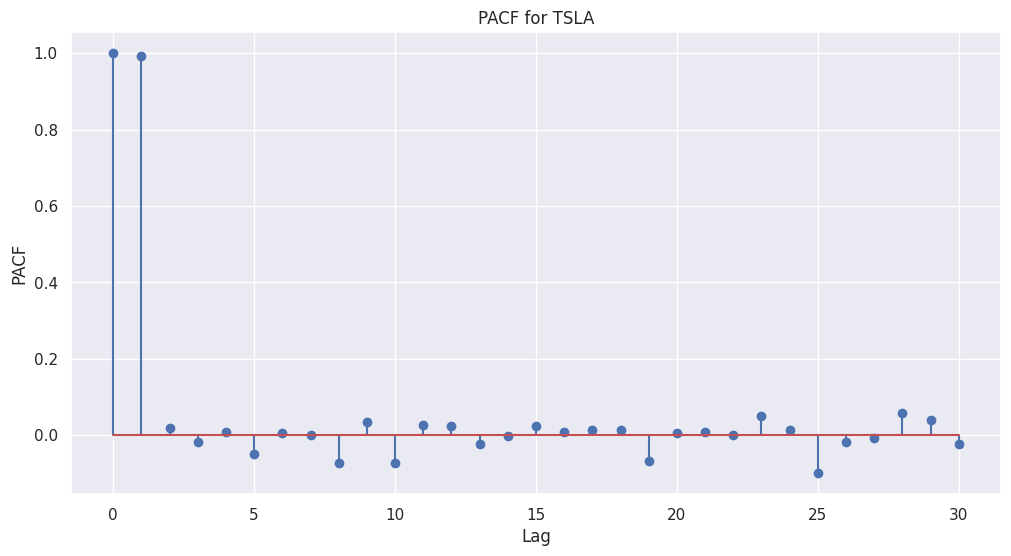

In [20]:
for symbol in symbols:
    df[f'{symbol}_Close_Lag1'] = df[symbol].shift(1)
    df[f'{symbol}_Close_Lag2'] = df[symbol].shift(2)
    df[f'{symbol}_Rolling_Mean_7'] = df[symbol].rolling(window=7).mean()
    df[f'{symbol}_Rolling_Mean_30'] = df[symbol].rolling(window=30).mean()
    df[f'{symbol}_Close_Pct_Change'] = df[symbol].pct_change()

    # Plot ACF and PACF
    plot_acf_pacf(df[symbol].dropna(), symbol)

# Drop NaN values after feature engineering
df.dropna(inplace=True)



# Modelling
1. **ARIMA Model**

  1. The Auto ARIMA function from the pmdarima library was used to identify the optimal parameters (p, d, q) for each stock based on the Akaike Information Criterion (AIC).
  2.  Forecasts were generated for the next 30 days.



2. **Gradient Boosting Model**

   1. The data was split into training and testing sets (80%/20%).
Features excluding the target variable (stock price) were used as input (X) and the closing price was used as the target variable (y).
  2. A Gradient Boosting Regressor was trained on the training data.
Predictions were made on the testing data for the next 30 days.

In [21]:
def arima_model(df, symbol):
    model = auto_arima(df[symbol], seasonal=False, trace=True, error_action='ignore', suppress_warnings=True)
    model.fit(df[symbol])
    forecast = model.predict(n_periods=30)
    return forecast


In [22]:
def gradient_boosting_model(df, symbol):
    train_size = int(len(df) * 0.8)
    train_data, test_data = df.iloc[:train_size], df.iloc[train_size:]

    X_train, y_train = train_data.drop(columns=[symbol]), train_data[symbol]
    X_test, y_test = test_data.drop(columns=[symbol]), test_data[symbol]

    gb_model = GradientBoostingRegressor()
    gb_model.fit(X_train, y_train)
    predictions = gb_model.predict(X_test)

    return predictions




Stock: AAPL
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4672.480, Time=0.93 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4666.752, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4667.096, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4667.019, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4666.629, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4668.511, Time=0.48 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.874 seconds
ARIMA Forecast for AAPL: 977     192.024185
978     192.024185
979     192.024185
980     192.024185
981     192.024185
982     192.024185
983     192.024185
984     192.024185
985     192.024185
986     192.024185
987     192.024185
988     192.024185
989     192.024185
990     192.024185
991     192.024185
992     192.024185
993     192.024185
994     192.024185
995     192.024185
996     192.024185
997     192.024185
998     192.024185
999     192.024185
1000    1

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Gradient Boosting Predictions for AAPL: [156.69645251 159.29893584 159.64366571 156.30863571 157.47137073
 160.51607806 160.26567283 162.36868807 164.64953313 164.17294786
 162.35980753 164.25485272 162.05631884 159.6152557  159.1036376
 163.7390711  164.09135561 163.62892236 164.64991511 165.98955368
 166.70203658 165.72172802 163.37014185 161.58246782 163.4057388
 168.08220957 168.57669864 167.50597783 167.58824427 167.47693859
 166.47581329 170.15520734 171.26505592 170.10081614 172.16417001
 171.4260109  171.07667561 171.12093062 171.23488307 171.70358153
 172.88157963 172.64399508 172.6347363  169.88373429 170.42999825
 170.8899496  173.58329664 175.0221783  173.60718321 175.52959194
 174.30604429 174.6333311  174.3575345  173.37870627 175.15583393
 173.96841916 175.61711567 174.60475807 174.23760028 175.22563589
 174.71787773 174.26648099 174.6788837  175.61948423 174.85375698
 174.39976884 175.20625405 174.74074786 174.52681709 176.9151636
 174.86961019 174.85982672 174.82298943

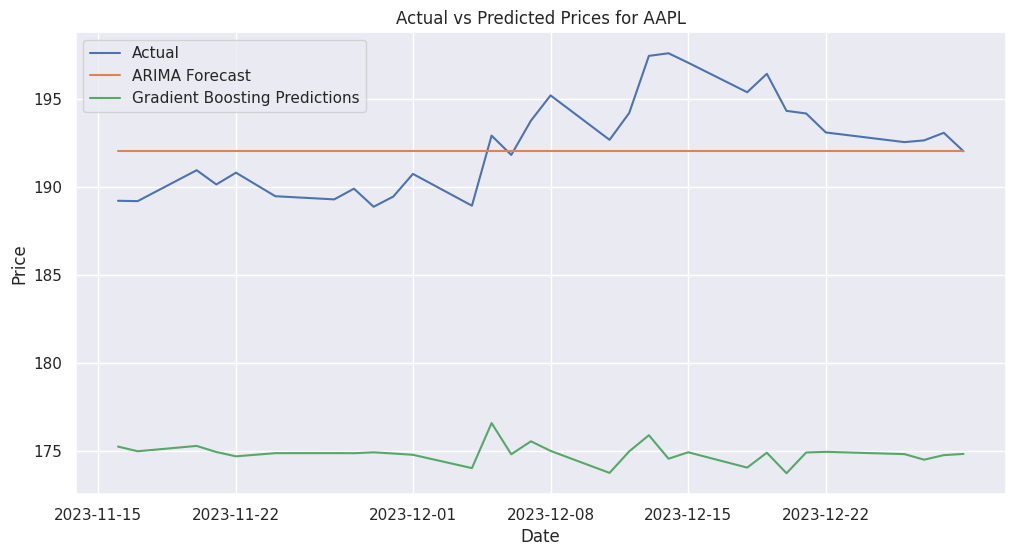


Stock: MSFT
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=3.32 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5002.393, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5003.637, Time=0.19 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5003.655, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5000.600, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5003.933, Time=1.40 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 5.396 seconds
ARIMA Forecast for MSFT: 977     151.940002
978     151.940002
979     151.940002
980     151.940002
981     151.940002
982     151.940002
983     151.940002
984     151.940002
985     151.940002
986     151.940002
987     151.940002
988     151.940002
989     151.940002
990     151.940002
991     151.940002
992     151.940002
993     151.940002
994     151.940002
995     151.940002
996     151.940002
997     151.940002
998     151.940002
999     151.940002
1000    151.94

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Gradient Boosting Predictions for MSFT: [ 98.94018943  97.65437251  97.11801164  97.06694639  96.72031294
  99.46241207 101.53026287 101.35693887 102.01928895 104.34350165
 101.58907065 101.27108349 100.55325347 101.13956342  99.165667
 101.60703572 102.77518815 102.66489242 102.02407356 104.10262752
 103.71458232 106.91521541 107.29778552 103.8931083  105.21287083
 112.36788252 105.98368209 104.44089112 101.92385958 104.00766128
 104.60868608 105.89167826 108.1658629  108.77542047 111.40625804
 112.46542223 109.77140549 111.76304658 112.74782319 115.53592178
 118.40431426 118.01357376 115.42259182 115.33561553 117.46255153
 115.38646357 120.43312936 120.81211499 120.88262035 122.72401521
 124.38109661 124.20584995 124.306247   120.3030228  123.69190495
 123.36780047 126.54249416 126.60475848 126.60485788 126.95095721
 125.97796547 123.36461746 122.99269069 128.09947937 129.79873313
 127.5741708  127.71721883 127.83477474 127.04306072 128.69922562
 129.90160772 129.90160772 129.1353416

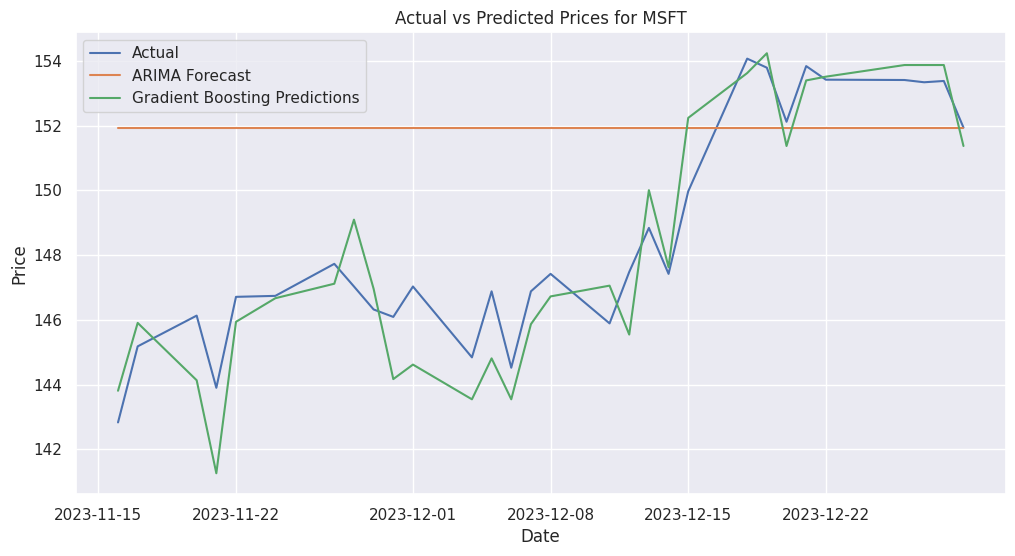


Stock: GOOGL
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4297.266, Time=1.74 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4294.727, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4294.739, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4294.731, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4293.609, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4296.738, Time=0.49 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 2.919 seconds
ARIMA Forecast for GOOGL: 977     139.529861
978     139.529861
979     139.529861
980     139.529861
981     139.529861
982     139.529861
983     139.529861
984     139.529861
985     139.529861
986     139.529861
987     139.529861
988     139.529861
989     139.529861
990     139.529861
991     139.529861
992     139.529861
993     139.529861
994     139.529861
995     139.529861
996     139.529861
997     139.529861
998     139.529861
999     139.529861
1000   

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Gradient Boosting Predictions for GOOGL: [101.21709653 103.8532407  104.59314607 102.4775782  101.5090519
 102.25441705 102.47891139 104.90353299 104.71737148 103.81472462
 103.98299836 108.4223693  107.53108667 105.96515123 106.15398876
 107.56969639 108.64490554 108.09273776 105.96515123 105.12736513
 105.75017615 106.92298194 107.63092178 103.94387347 105.09987679
 108.47903995 107.36213134 107.36213134 105.84318072 106.9457722
 106.17677902 105.83313811 108.51091378 108.28253482 112.75278261
 115.55056206 117.51184379 117.56138138 118.80787545 120.98074289
 122.52505381 123.01889986 124.18396296 122.43268934 122.13418726
 123.5246453  125.13847423 123.81832341 123.79022225 125.02827331
 125.17228265 124.95128535 127.82697089 125.0641477  124.24004765
 124.3428114  124.77597148 124.79895336 124.8739226  125.4578093
 125.19168493 124.69002971 122.31354462 125.08919871 123.63113453
 120.24233282 120.21619707 120.84854708 119.93444886 121.34971338
 121.29580963 122.63505541 121.3160956

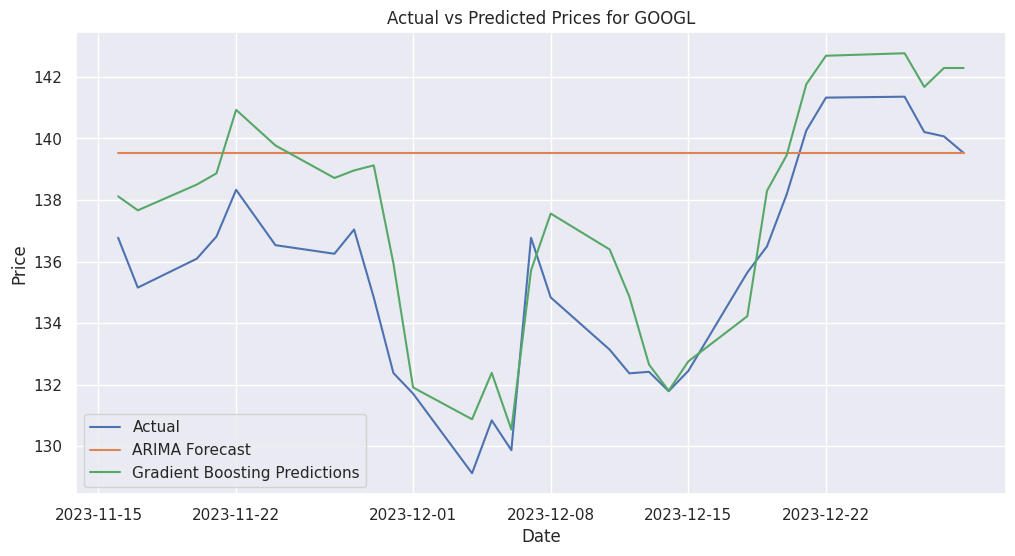


Stock: AMZN
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5827.907, Time=1.42 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5832.341, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5823.728, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5823.109, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5832.094, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5824.168, Time=0.38 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=5824.498, Time=0.30 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5826.104, Time=0.39 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=5823.337, Time=0.07 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 3.044 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


ARIMA Forecast for AMZN: 977     374.800623
978     375.003528
979     375.206433
980     375.409339
981     375.612244
982     375.815149
983     376.018054
984     376.220960
985     376.423865
986     376.626770
987     376.829676
988     377.032581
989     377.235486
990     377.438392
991     377.641297
992     377.844202
993     378.047107
994     378.250013
995     378.452918
996     378.655823
997     378.858729
998     379.061634
999     379.264539
1000    379.467445
1001    379.670350
1002    379.873255
1003    380.076160
1004    380.279066
1005    380.481971
1006    380.684876
dtype: float64
Gradient Boosting Predictions for AMZN: [269.80820559 272.09439117 274.43101617 270.50993951 270.14923431
 275.30149506 279.67234075 280.93541426 281.00655415 279.05197468
 276.7191761  284.26733521 285.70732932 279.12920233 278.2169479
 282.23784053 281.59741638 281.38435372 283.39376119 281.7645574
 280.34580307 279.17088691 277.03345645 272.18551267 283.88642111
 293.38960191 295.6909

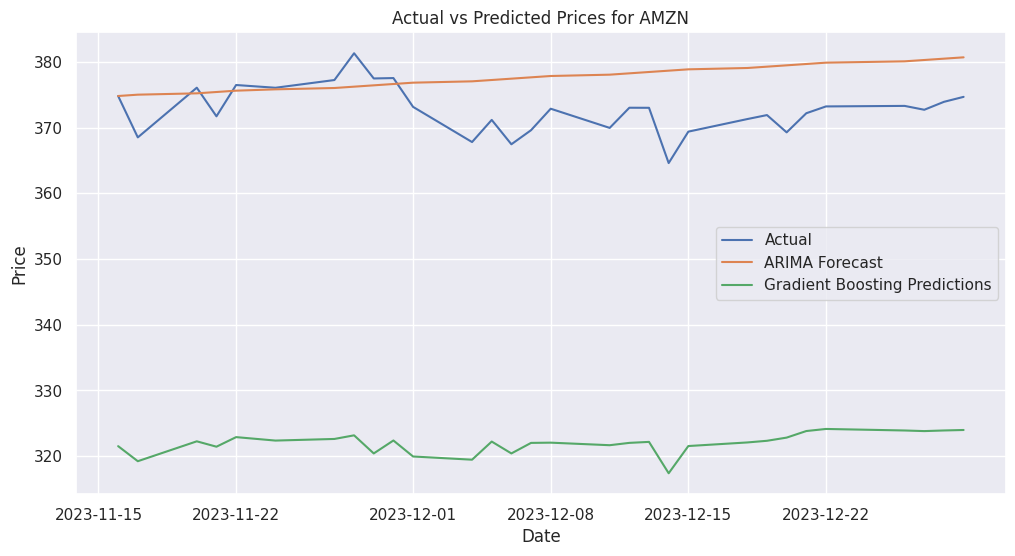


Stock: TSLA
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=6993.241, Time=1.63 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6986.930, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6988.002, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6988.028, Time=0.36 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6985.449, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=6989.260, Time=0.64 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 3.000 seconds
ARIMA Forecast for TSLA: 977     248.479996
978     248.479996
979     248.479996
980     248.479996
981     248.479996
982     248.479996
983     248.479996
984     248.479996
985     248.479996
986     248.479996
987     248.479996
988     248.479996
989     248.479996
990     248.479996
991     248.479996
992     248.479996
993     248.479996
994     248.479996
995     248.479996
996     248.479996
997     248.479996
998     248.479996
999     248.479996
1000    2

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Gradient Boosting Predictions for TSLA: [189.00147111 192.90432742 190.02225939 193.11436482 191.6482711
 198.32980237 196.8333521  205.79256497 195.37348841 193.66512415
 188.20983061 191.45988932 191.61953786 193.05300839 182.7986522
 187.23271305 188.93576842 192.52413273 186.60324799 181.93978408
 173.58038719 171.18639352 165.59929954 167.95487557 163.34950083
 157.27066249 172.79128823 166.44134881 167.52073372 168.32709173
 167.95939159 175.71376832 176.94977193 173.34455713 174.73721895
 171.91778766 171.53907185 168.60144856 166.83620147 174.87484248
 178.46579511 178.39031335 183.73042495 186.83013717 184.28688193
 181.9067855  193.35285126 198.27919318 204.74070336 207.00346676
 209.12049968 213.2246435  222.84353909 225.26233628 231.76011708
 246.01459541 249.1536631  258.93025252 254.71542739 254.40015702
 262.66848328 283.31906094 265.23054713 264.19794662 253.92680738
 243.35091987 256.44605848 257.96533797 259.87150746 261.08062504
 284.54696373 281.11729827 285.5264503

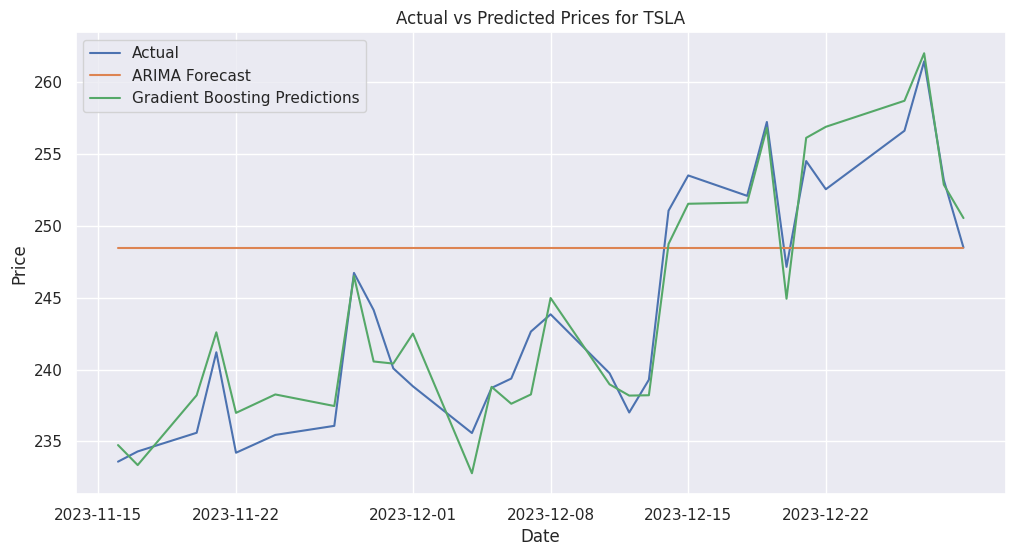

In [23]:
for symbol in symbols:
    print(f'\nStock: {symbol}')

    # ARIMA forecast
    arima_forecast = arima_model(df, symbol)
    print(f'ARIMA Forecast for {symbol}: {arima_forecast}')

    # Gradient Boosting predictions
    gb_predictions = gradient_boosting_model(df, symbol)
    print(f'Gradient Boosting Predictions for {symbol}: {gb_predictions}')

    # Evaluate ARIMA
    arima_rmse, arima_mae = evaluate_forecast(df[symbol][-30:], arima_forecast[-30:])
    print(f'ARIMA RMSE for {symbol}: {arima_rmse}')
    print(f'ARIMA MAE for {symbol}: {arima_mae}')

    # Evaluate Gradient Boosting
    gb_rmse, gb_mae = evaluate_forecast(df[symbol][-30:], gb_predictions[-30:])
    print(f'Gradient Boosting RMSE for {symbol}: {gb_rmse}')
    print(f'Gradient Boosting MAE for {symbol}: {gb_mae}')

    # Plotting actual vs predicted
    plt.figure(figsize=(12, 6))
    plt.plot(df.index[-30:], df[symbol][-30:], label='Actual')
    plt.plot(df.index[-30:], arima_forecast[-30:], label='ARIMA Forecast')
    plt.plot(df.index[-30:], gb_predictions[-30:], label='Gradient Boosting Predictions')
    plt.title(f'Actual vs Predicted Prices for {symbol}')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()
